In [106]:
#!git clone git@github.com:cisagov/vulnrichment.git    

## Read CWE values

1. Clone Vulnrichment JSON files
2. Extract the CVE Description, and CWE info from the Vulnrichment JSON files to a CSV file
   1. Indicate which CNA assigned the CWE 
   1. One CWE per line per CVE
   2. The providerMetadata 
      1. shortName 
      2. dateUpdated
3. Clean up the Description 
4. Save all entries to a file
5. Save entries with CWEs to a file. This is the one that will be input to CWE Map to assign or validate a CWE.

A CVE can contain no CWEs e.g. https://github.com/cisagov/vulnrichment/blob/ad2ab8e7bc7a207cd306ba2b876eff568e239e3b/2021/1xxx/CVE-2021-1675.json#L12

A CWE can be in one or both
* ADP container (CISA)
* CNA container 

Examples
* 2024/32xxx/CVE-2024-32017.json
    * https://github.com/cisagov/vulnrichment/blob/4380ad1a5f932ba6a29fd01dc825d03a9547196d/2024/32xxx/CVE-2024-32017.json#L19 has CWE-120 in the CNA container.
*  2024/0xxx/CVE-2024-0042.json has 
     * 'unknown' in the CNA container https://github.com/cisagov/vulnrichment/blob/7a8e01764e5ae28d6ef713ecf7c12b9d618c6254/2024/0xxx/CVE-2024-0042.json#L25
     * CWE-843 in the ADP container https://github.com/cisagov/vulnrichment/blob/7a8e01764e5ae28d6ef713ecf7c12b9d618c6254/2024/0xxx/CVE-2024-0042.json#L119

In [118]:
import os
import json
import csv
import pandas as pd
import numpy as np
import re
import unicodedata
import matplotlib.pyplot as plt
from datetime import datetime

In [108]:
# Files
root_directory = './vulnrichment/' # Directory containing JSON files
output_file_path = 'data_out/extracted_cwe_info.csv'# All entries
cwe_only_output_file_path = 'data_out/extracted_cwe_info_only.csv' # Entries with CWEs only
cwe_only_cisa_adp_output_file_path = 'data_out/extracted_cwe_info_cisa_adp_only.csv' # Entries with CWEs only


In [109]:
def extract_cwe_info_from_json(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)
        cwe_info_list = []
        filename = os.path.basename(file_path)
        cve_id = os.path.splitext(filename)[0]
        
        containers = data.get('containers', {})
        if containers:
            for container_name, container_data in containers.items():
                cwe_info_list.extend(extract_cwe_info(container_data, filename, container_name))

        # Extract CVE description from the first container that has it
        cve_description = ''
        for container_data in containers.values():
            cve_description = extract_cve_description(container_data)
            if cve_description:
                break

        for info in cwe_info_list:
            info['CVE_Description'] = cve_description

        return cwe_info_list

def extract_cwe_info(container_data, filename, container_name):
    cve_id = os.path.splitext(os.path.basename(filename))[0]
    cwe_info = []
    
    if isinstance(container_data, dict):
        container_data = [container_data]
    
    for entry in container_data:
        info = {
            'cve_id': cve_id,
            'Container': container_name
        }
        
        # Extract providerMetadata fields
        provider_metadata = entry.get('providerMetadata', {})
        for key, value in provider_metadata.items():
            info[f'{container_name}_providerMetadata_{key}'] = value
        
        problem_types = entry.get('problemTypes', [])
        cwe_found = False
        for problem in problem_types:
            descriptions = problem.get('descriptions', [])
            for description in descriptions:
                cwe_id = description.get('cweId')
                cwe_description = description.get('description')
                if cwe_id and cwe_description:
                    cwe_info_entry = info.copy()
                    cwe_info_entry.update({
                        'CWE_ID': cwe_id,
                        'CWE_Description': cwe_description
                    })
                    cwe_info.append(cwe_info_entry)
                    cwe_found = True
        
        # If no CWE info found, still add the entry with providerMetadata
        if not cwe_found:
            cwe_info.append(info)
    
    return cwe_info


def get_cve_description(container_data):
    descriptions = container_data.get('descriptions', []) if isinstance(container_data, dict) else container_data
    for desc in descriptions:
        if desc.get('lang') == 'en':
            return desc.get('value', '')
    return ''

def extract_cwe_info_from_directory(root_dir):
    all_cwe_info = []
    for root, _, files in os.walk(root_dir):
        for file_name in files:
            if file_name.endswith('.json'):
                file_path = os.path.join(root, file_name)
                cwe_info = extract_cwe_info_from_json(file_path)
                if cwe_info:
                    all_cwe_info.extend(cwe_info)
    return all_cwe_info

def escape_newlines(text):
    if isinstance(text, str):
        return text.replace('\n', '\\n').replace('\r', '\\r')
    return text


def clean_unicode(text):
    if not isinstance(text, str):
        return text
    
    # Normalize Unicode characters
    text = unicodedata.normalize('NFKD', text)
    
    # Remove control characters
    text = re.sub(r'[\x00-\x1f\x7f-\x9f]', '', text)
    
    # Replace special spaces and dashes with their ASCII equivalents
    text = text.replace('\u00A0', ' ')  # Non-breaking space
    text = text.replace('\u2013', '-')  # En dash
    text = text.replace('\u2014', '-')  # Em dash
    
    # Remove other potentially problematic characters
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    
    return text

cwe_info_list = extract_cwe_info_from_directory(root_directory)

# Convert the list of dictionaries to a DataFrame and save it as a CSV file
df = pd.DataFrame(cwe_info_list)



# Apply text cleaning to all string columns
for column in df.columns:
    if df[column].dtype == 'object':
        df[column] = df[column].apply(lambda x: clean_unicode(escape_newlines(x)))


# Save as CSV file with proper quoting
df.to_csv(output_file_path, index=False,quoting=csv.QUOTE_ALL, escapechar='\\') # safe CSV

df

,cve_id,Container,adp_providerMetadata_orgId,adp_providerMetadata_shortName,adp_providerMetadata_dateUpdated,CVE_Description,cna_providerMetadata_orgId,cna_providerMetadata_shortName,cna_providerMetadata_dateUpdated,CWE_ID,CWE_Description
0,CVE-2021-1675,adp,134c704f-9b21-4f2e-91b3-4a467353bcc0,CISA-ADP,2024-06-20T19:19:41.621Z,,NaN,NaN,NaN,NaN,NaN
1,CVE-2021-1675,cna,NaN,NaN,NaN,,f38d906d-7342-40ea-92c1-6c4a2c6478c8,microsoft,2024-05-29T14:55:40.040Z,NaN,NaN
2,CVE-2021-32039,cna,NaN,NaN,NaN,Users with appropriate file access may be able...,a39b4221-9bd0-4244-95fc-f3e2e07f1deb,mongodb,2024-01-23T16:28:19.416Z,CWE-522,CWE-522: Insufficiently Protected Credentials
3,CVE-2021-32039,adp,134c704f-9b21-4f2e-91b3-4a467353bcc0,CISA-ADP,2024-04-22T18:20:28.836Z,Users with appropriate file access may be able...,NaN,NaN,NaN,NaN,NaN
4,CVE-2021-42574,adp,134c704f-9b21-4f2e-91b3-4a467353bcc0,CISA-ADP,2024-06-11T15:16:54.431Z,An issue was discovered in the Bidirectional A...,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
30252,CVE-2024-37313,cna,NaN,NaN,NaN,Nextcloud server is a self hosted personal clo...,a0819718-46f1-4df5-94e2-005712e83aaa,GitHub_M,2024-06-14T14:50:44.035Z,CWE-287,CWE-287: Improper Authentication
30253,CVE-2024-37019,cna,NaN,NaN,NaN,Northern.tech Mender Enterprise before 3.6.4 a...,8254265b-2729-46b6-b9e3-3dfca2d5bfca,mitre,2024-06-03T18:02:10.532837,NaN,NaN
30254,CVE-2024-37019,adp,134c704f-9b21-4f2e-91b3-4a467353bcc0,CISA-ADP,2024-06-04T14:49:54.923Z,Northern.tech Mender Enterprise before 3.6.4 a...,NaN,NaN,NaN,CWE-287,CWE-287 Improper Authentication
30255,CVE-2024-41184,cna,NaN,NaN,NaN,In the vrrp_ipsets_handler handler (fglobal_pa...,8254265b-2729-46b6-b9e3-3dfca2d5bfca,mitre,2024-07-18T00:35:08.422345,NaN,NaN


## Check Counts Of Things 

In [110]:
df.CWE_ID.count()

10430

In [111]:
df.CWE_ID.value_counts()

CWE-79      1620
CWE-89       658
CWE-121      429
CWE-862      426
CWE-352      355
            ... 
CWE-409        1
CWE-424        1
CWE-1068       1
CWE-657        1
CWE-1240       1
Name: CWE_ID, Length: 422, dtype: int64

In [112]:
df.CWE_ID.nunique()

422

In [113]:
df.Container.value_counts()

cna    15236
adp    15021
Name: Container, dtype: int64

In [114]:
#Does each CISA ADP Container have "shortName": "CISA-ADP". Container adp counts should match "shortName": "CISA-ADP" counts
df.adp_providerMetadata_shortName.value_counts()


CISA-ADP    15021
Name: adp_providerMetadata_shortName, dtype: int64

## Save Entries with CWEs only

In [115]:
cwe_filtered = df[df['CWE_ID'].str.startswith('CWE-', na=False)]

# Save as CSV file with proper quoting
cwe_filtered.to_csv(cwe_only_output_file_path, index=False, quoting=csv.QUOTE_ALL, escapechar='\\') # safe CSV
    

cwe_filtered

,cve_id,Container,adp_providerMetadata_orgId,adp_providerMetadata_shortName,adp_providerMetadata_dateUpdated,CVE_Description,cna_providerMetadata_orgId,cna_providerMetadata_shortName,cna_providerMetadata_dateUpdated,CWE_ID,CWE_Description
2,CVE-2021-32039,cna,NaN,NaN,NaN,Users with appropriate file access may be able...,a39b4221-9bd0-4244-95fc-f3e2e07f1deb,mongodb,2024-01-23T16:28:19.416Z,CWE-522,CWE-522: Insufficiently Protected Credentials
10,CVE-2021-35001,cna,NaN,NaN,NaN,BMC Track-It! GetData Missing Authorization In...,99f1926a-a320-47d8-bbb5-42feb611262e,zdi,2024-05-07T22:54:53.388Z,CWE-862,CWE-862: Missing Authorization
12,CVE-2021-35000,cna,NaN,NaN,NaN,OpenBSD Kernel Multicast Routing Uninitialized...,99f1926a-a320-47d8-bbb5-42feb611262e,zdi,2024-05-07T22:54:52.586Z,CWE-908,CWE-908: Use of Uninitialized Resource
16,CVE-2021-35002,cna,NaN,NaN,NaN,BMC Track-It! Unrestricted File Upload Remote ...,99f1926a-a320-47d8-bbb5-42feb611262e,zdi,2024-05-07T22:54:54.220Z,CWE-434,CWE-434: Unrestricted Upload of File with Dang...
18,CVE-2021-35559,adp,134c704f-9b21-4f2e-91b3-4a467353bcc0,CISA-ADP,2024-06-25T16:05:50.566Z,"Vulnerability in the Java SE, Oracle GraalVM E...",NaN,NaN,NaN,CWE-400,CWE-400 Uncontrolled Resource Consumption
...,...,...,...,...,...,...,...,...,...,...,...
30248,CVE-2024-37350,cna,NaN,NaN,NaN,There is a cross-site scripting vulnerability ...,b6533044-ea05-4482-8458-7bddeca0d079,Absolute,2024-06-20T17:18:33.952Z,CWE-79,CWE-79 Improper Neutralization of Input During...
30250,CVE-2024-37535,adp,134c704f-9b21-4f2e-91b3-4a467353bcc0,CISA-ADP,2024-06-10T12:55:15.708Z,GNOME VTE before 0.76.3 allows an attacker to ...,NaN,NaN,NaN,CWE-400,CWE-400 Uncontrolled Resource Consumption
30252,CVE-2024-37313,cna,NaN,NaN,NaN,Nextcloud server is a self hosted personal clo...,a0819718-46f1-4df5-94e2-005712e83aaa,GitHub_M,2024-06-14T14:50:44.035Z,CWE-287,CWE-287: Improper Authentication
30254,CVE-2024-37019,adp,134c704f-9b21-4f2e-91b3-4a467353bcc0,CISA-ADP,2024-06-04T14:49:54.923Z,Northern.tech Mender Enterprise before 3.6.4 a...,NaN,NaN,NaN,CWE-287,CWE-287 Improper Authentication


## Save Entries with CWEs assigned by CISA ADP only

In [116]:
cisa_adp_entries = cwe_filtered[cwe_filtered['adp_providerMetadata_shortName'] == 'CISA-ADP']

# Save as CSV file with proper quoting
cisa_adp_entries.to_csv(cwe_only_cisa_adp_output_file_path, index=False,quoting=csv.QUOTE_ALL, escapechar='\\') # safe CSV

cisa_adp_entries

,cve_id,Container,adp_providerMetadata_orgId,adp_providerMetadata_shortName,adp_providerMetadata_dateUpdated,CVE_Description,cna_providerMetadata_orgId,cna_providerMetadata_shortName,cna_providerMetadata_dateUpdated,CWE_ID,CWE_Description
18,CVE-2021-35559,adp,134c704f-9b21-4f2e-91b3-4a467353bcc0,CISA-ADP,2024-06-25T16:05:50.566Z,"Vulnerability in the Java SE, Oracle GraalVM E...",NaN,NaN,NaN,CWE-400,CWE-400 Uncontrolled Resource Consumption
23,CVE-2021-26928,adp,134c704f-9b21-4f2e-91b3-4a467353bcc0,CISA-ADP,2024-05-01T15:18:46.280Z,BIRD through 2.0.7 does not provide functional...,NaN,NaN,NaN,CWE-306,CWE-306 Missing Authentication for Critical Fu...
29,CVE-2021-26918,adp,134c704f-9b21-4f2e-91b3-4a467353bcc0,CISA-ADP,2024-05-01T15:09:54.735Z,The ProBot bot through 2021-02-08 for Discord ...,NaN,NaN,NaN,CWE-434,CWE-434 Unrestricted Upload of File with Dange...
114,CVE-2021-34983,adp,134c704f-9b21-4f2e-91b3-4a467353bcc0,CISA-ADP,2024-05-08T15:08:02.757Z,NETGEAR Multiple Routers httpd Missing Authent...,NaN,NaN,NaN,CWE-120,CWE-120 Buffer Copy without Checking Size of I...
148,CVE-2021-33990,adp,134c704f-9b21-4f2e-91b3-4a467353bcc0,CISA-ADP,2024-07-12T15:32:38.330Z,Liferay Portal 6.2.5 allows Command=FileUpload...,NaN,NaN,NaN,CWE-78,CWE-78 Improper Neutralization of Special Elem...
...,...,...,...,...,...,...,...,...,...,...,...
30231,CVE-2024-37762,adp,134c704f-9b21-4f2e-91b3-4a467353bcc0,CISA-ADP,2024-07-08T15:13:35.601Z,MachForm up to version 21 is affected by an au...,NaN,NaN,NaN,CWE-434,CWE-434 Unrestricted Upload of File with Dange...
30233,CVE-2024-37634,adp,134c704f-9b21-4f2e-91b3-4a467353bcc0,CISA-ADP,2024-06-13T20:21:11.912Z,TOTOLINK A3700R V9.1.2u.6165_20211012 was disc...,NaN,NaN,NaN,CWE-121,CWE-121 Stack-based Buffer Overflow
30250,CVE-2024-37535,adp,134c704f-9b21-4f2e-91b3-4a467353bcc0,CISA-ADP,2024-06-10T12:55:15.708Z,GNOME VTE before 0.76.3 allows an attacker to ...,NaN,NaN,NaN,CWE-400,CWE-400 Uncontrolled Resource Consumption
30254,CVE-2024-37019,adp,134c704f-9b21-4f2e-91b3-4a467353bcc0,CISA-ADP,2024-06-04T14:49:54.923Z,Northern.tech Mender Enterprise before 3.6.4 a...,NaN,NaN,NaN,CWE-287,CWE-287 Improper Authentication


## Summary Stats

In [117]:
print("\nData Summary:")
print(f"{len(df)} \t Total number of entries")
print(f"{df.CWE_ID.count()} \t Number of entries with CWE_ID ")
print(f"{len(cisa_adp_entries)} \t Number of CISA ADP entries with CWE_ID")
print(f"\nNumber of unique CWE_IDs \n{df.CWE_ID.value_counts()}")




Data Summary:
30257 	 Total number of entries
10430 	 Number of entries with CWE_ID 
1884 	 Number of CISA ADP entries with CWE_ID

Number of unique CWE_IDs 
CWE-79      1620
CWE-89       658
CWE-121      429
CWE-862      426
CWE-352      355
            ... 
CWE-409        1
CWE-424        1
CWE-1068       1
CWE-657        1
CWE-1240       1
Name: CWE_ID, Length: 422, dtype: int64


# Cumulative Plot of CWEs assigned by CISA ADP

In [133]:
def plot_cumulative_and_daily_entries(df):
    if 'adp_providerMetadata_dateUpdated' not in df.columns:
        print("Column 'adp_providerMetadata_dateUpdated' not found in the DataFrame")
        return

    # Create a copy of the DataFrame to avoid modifying the original
    df_copy = df.copy()

    # Convert dateUpdated to datetime
    df_copy.loc[:, 'dateUpdated'] = pd.to_datetime(df_copy['adp_providerMetadata_dateUpdated'], format='%Y-%m-%dT%H:%M:%S.%fZ')

    # Group by date and count entries for each day
    daily_counts = df_copy.groupby(df_copy['dateUpdated'].dt.date).size().reset_index(name='count')
    daily_counts['dateUpdated'] = pd.to_datetime(daily_counts['dateUpdated'])

    # Sort the dataframe by date
    daily_counts = daily_counts.sort_values('dateUpdated')

    # Calculate cumulative counts
    daily_counts['cumulative_count'] = daily_counts['count'].cumsum()

    # Create the plot with a light background
    plt.style.use('seaborn')
    fig, ax1 = plt.subplots(figsize=(20, 10), facecolor='#F0F0F0')
    ax1.set_facecolor('#F0F0F0')

    # Plot cumulative count
    color = 'darkblue'
    ax1.set_xlabel('Date', color='black', fontweight='bold')
    ax1.set_ylabel('Cumulative Count', color=color, fontweight='bold')
    ax1.plot(daily_counts['dateUpdated'], daily_counts['cumulative_count'], color=color, linewidth=2)
    ax1.tick_params(axis='y', labelcolor=color)

    # Create a second y-axis for daily count
    ax2 = ax1.twinx()
    color = 'darkred'
    ax2.set_ylabel('Daily Count', color=color, fontweight='bold')
    ax2.bar(daily_counts['dateUpdated'], daily_counts['count'], alpha=0.3, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    # Set title and adjust layout
    plt.title('Cumulative and Daily Count of CISA ADP CWE Entries Over Time', color='black', fontweight='bold', fontsize=16)
    fig.tight_layout()

    # Rotate and align the tick labels so they look better
    fig.autofmt_xdate()

    # Add a grid for better readability
    ax1.grid(True, linestyle='--', alpha=0.7)

    # Add a legend
    ax1.legend(['Cumulative Count'], loc='upper left', frameon=True, facecolor='white', edgecolor='black')
    ax2.legend(['Daily Count'], loc='upper right', frameon=True, facecolor='white', edgecolor='black')

    # Save the plot
    plt.savefig('cumulative_and_daily_entries_plot.png', dpi=300, bbox_inches='tight')
    print("Cumulative and daily plot has been saved as 'cumulative_and_daily_entries_plot.png'")

    # Show some statistics
    print(f"\nDate range: from {daily_counts['dateUpdated'].min().date()} to {daily_counts['dateUpdated'].max().date()}")
    print(f"Total number of entries: {daily_counts['cumulative_count'].iloc[-1]}")
    print(f"Maximum daily entries: {daily_counts['count'].max()} on {daily_counts.loc[daily_counts['count'].idxmax(), 'dateUpdated'].date()}")
    print(f"Average daily entries: {daily_counts['count'].mean():.2f}")


Cumulative and daily plot has been saved as 'cumulative_and_daily_entries_plot.png'

Date range: from 2024-04-18 to 2024-07-18
Total number of entries: 1884
Maximum daily entries: 101 on 2024-07-16
Average daily entries: 25.81


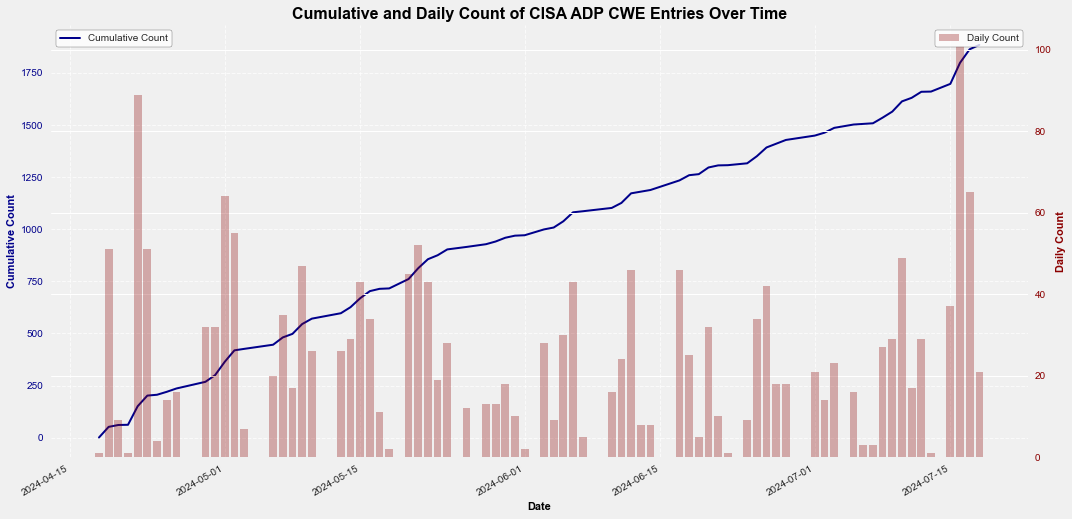

In [134]:
plot_cumulative_and_daily_entries(cisa_adp_entries)